In [2]:
!pip install mplcyberpunk

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm

In [52]:
# X_train ve y_train: Eğitim görüntüleri ve bunlara karşılık gelen etiketlerin saklandığı listeler.

X_train = []
y_train = []

# Veri kümesindeki dört sınıf (etiket) tanımlanıyor:

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

#image_size: Görüntülerin yeniden boyutlandırılacağı hedef boyut (150x150 piksel)

image_size = 150

for i in labels:

    # Her bir etiketin görüntüleri için eğitim verisi dosyaları yükleniyor.

    folderPath = os.path.join('/content/drive/MyDrive/brain2/brain/Training',i)
    for j in tqdm(os.listdir(folderPath)):

        """
    Görüntüler OpenCV ile okunuyor.
    cv2.resize() kullanılarak tüm görüntüler 150x150 piksele yeniden boyutlandırılıyor.
    Yeniden boyutlandırılmış görüntüler X_train listesine, etiketleri ise y_train listesine ekleniyor.

        """
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:

    #Eğitim verisine benzer şekilde, test görüntüleri de aynı işlemlerle yükleniyor:

    folderPath = os.path.join('/content/drive/MyDrive/brain2/brain/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

        """

    X_train: Tüm görüntülerin piksel değerlerini içeren NumPy dizisi.
    y_train: Görüntülere karşılık gelen etiketlerin bulunduğu NumPy dizisi.
    Bu işlem, verilerin TensorFlow veya başka bir derin öğrenme çerçevesinde işlenmesi için gerekli.

        """

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 118.37it/s]


In [5]:
"""
Google Drive'a bağlanmamızın sebebi, eğitim ve test verilerimizin (MRI görüntüleri ve etiketleri)
Google Drive'da saklanıyor olmasıdır. Özellikle Colab gibi bir ortam kullanıyorsan, Colab'in çalışma
alanı geçici olduğundan ve her yeniden başlattığında verilerin silindiğinden, kalıcı olarak
sakladığımız Google Drive'ı bağlamak gerekiyor.

"""


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


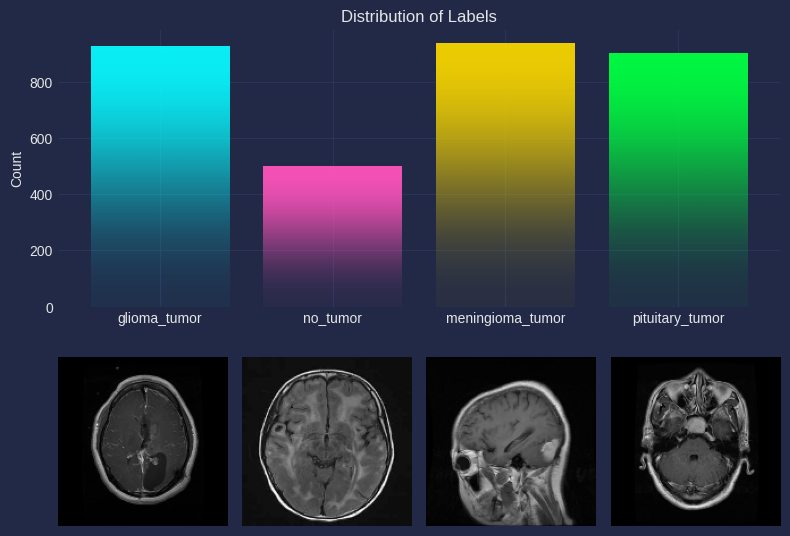

In [53]:
# Calculate the bar plot for each label


"""

Neden Yapıyoruz?:
Her sınıfın (örneğin: "glioma_tumor" veya "no_tumor")
kaç tane görüntüsü olduğunu öğrenmek istiyoruz.

Ne Oluyor?:
labels: Sınıf isimlerini içeriyor (örneğin: "glioma_tumor").
y_train == label: Hangi görüntülerin bu sınıfa ait olduğunu kontrol ediyor.
np.sum(...): Bu sınıfa ait toplam görüntü sayısını hesaplıyor.

Sonuç: Şuna benzer bir tablo oluşuyor:

label_counts = {'glioma_tumor': 500, 'no_tumor': 600, 'meningioma_tumor': 400, 'pituitary_tumor': 550}

"""

label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart

"""
Neden Yapıyoruz?: Grafiğin boyutunu ayarlıyoruz.
Bu, grafiğin ekranda çok küçük ya da çok büyük görünmesini engelliyor.
Sonuç: Grafik 8 birim genişlikte, 6 birim yükseklikte oluyor.

"""

plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram

"""

Neden Yapıyoruz?: Etiketlerin (sınıfların) sayısını görsel olarak göstermek istiyoruz.
Ne Oluyor?:
plt.subplot(2, 1, 1): Grafik 2 satıra ayrılıyor ve bu bar grafiği 1. satırda yer alıyor.

Grafik alanımız şu şekilde bölünür:

-----------------
|       1       |
-----------------
|       2       |
-----------------

plt.bar(...):
label_counts.keys(): Sınıfların isimleri (örneğin, "glioma_tumor").
label_counts.values(): Her sınıfa ait görüntü sayıları.
color=colors: Çubukların farklı renklerde olmasını sağlıyor.
mplcyberpunk.add_bar_gradient(...): Çubuklara renk geçişi efekti ekliyor. Süsleme gibi düşünebilirsin. 😊
Sonuç: Her sınıfın kaç görüntüsü olduğunu gösteren bir bar grafiği çıkıyor.


"""

plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label

"""

Neden Yapıyoruz?: Her sınıfın neye benzediğini görmek istiyoruz.
Ne Oluyor?:

k, görüntülerin sırasını ve hangi kareye yerleştirileceğini kontrol eder.

for i in labels: Her sınıf (örneğin, "glioma_tumor") için işlem yap.

j, etiket listesindeki (y_train) doğru sınıfa ait görüntüyü bulmak için kullanılır.

while True: O sınıfa ait ilk görüntüyü bulana kadar döngü çalışıyor.
if y_train[j] == i:
y_train[j]: Görüntülerin etiketlerini kontrol ediyor.
Eğer o görüntü, döngüdeki sınıfa aitse (i), o görüntüyü seçiyoruz.
plt.subplot(2, 4, k + 5): Bu görüntüyü alt grafiklerden birine yerleştiriyoruz.
Grafik 2 satır ve 4 sütundan oluşuyor. 5. kareden itibaren her sınıfın görüntüsünü yerleştiriyoruz.
plt.imshow(X_train[j]): Seçilen görüntüyü ekranda gösteriyoruz.
plt.axis('off'): Görüntü etrafındaki eksenleri kaldırıyoruz (görünmesin diye).
k += 1: Bir görüntü eklendiği için sıradaki kutuya geçiyoruz.
Sonuç: Her sınıf için bir örnek görüntü, alt grafiklerde gösteriliyor

"""

k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

"""
Neden Yapıyoruz?:
plt.tight_layout(): Görsellerin ve grafiğin üst üste binmesini engelliyor.
Daha temiz bir düzen oluşturuyor.
plt.show(): Grafiği ekrana gösteriyor.

"""
plt.tight_layout()

In [54]:
"""
Bu kod, eğitim verilerini (X_train) ve etiketlerini (y_train) rastgele bir şekilde karıştırır.
shuffle fonksiyonu, verilerin sırasını değiştirir ancak girişler (X_train)
ve etiketler (y_train) arasındaki bağlantıyı korur.

Neden Kullanılır?
Modelin Daha İyi Öğrenmesi İçin: Veriler sıralıysa
(örneğin, önce bir sınıfa ait tüm veriler, sonra diğer sınıfa ait veriler),
model bu düzeni öğrenmeye çalışabilir ve genellemede başarısız olabilir.
Karıştırmak, modelin daha iyi genelleme yapmasını sağlar.

"""


X_train, y_train = shuffle(X_train,y_train, random_state=101)


In [55]:
"""
Bu kod, eğitim (train) ve test (test) verilerini ayırır.
train_test_split fonksiyonu, modelin eğitimi için kullanılacak veri
ile performansını değerlendirmek için kullanılacak veriyi rastgele böler.

Açıklama:
test_size=0.1: Verilerin %10'u test verisi, %90'ı eğitim verisi olarak ayrılır.
random_state=101: Rastgele ayırma işleminin her çalıştırmada aynı
şekilde gerçekleşmesini sağlar (tekrarlanabilirlik).

Sonuç:
X_train ve y_train: Modelin eğitilmesi için kullanılacak girişler ve etiketler.
X_test ve y_test: Modelin test edilmesi için kullanılacak girişler ve etiketler.

"""


X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [56]:
"""

y_train_new.append(labels.index(i))

Amaç: y_train ve y_test içindeki sınıf isimlerini
('glioma_tumor', 'no_tumor' gibi) sırasıyla 0, 1, 2, 3 gibi sayısal değerlere çevirir.
labels.index(i) her sınıfın listedeki sırasını alır. Örneğin:
'glioma_tumor' → 0
'no_tumor' → 1


y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

Amaç: Etiketleri one-hot vektörlerine dönüştürmek.
Bu, her sınıfı bir dizi içinde temsil eder:

Örneğin:
0 → [1, 0, 0, 0] (glioma_tumor)
1 → [0, 1, 0, 0] (no_tumor)

Projen İçin Anlamı

Sınıflarınızı Modelin Anlayacağı Şekle Getirir:
Model, metin veya string ifadelerle çalışamaz,
bu nedenle sınıflar sayısal değerlere ve daha sonra one-hot encoding'e dönüştürülür.

Kategorik Çıkışlar için Gereklidir: Modelin çok sınıflı bir problemi
çözmesi için bu format gereklidir. Örneğin,
sınıflandırma sonuçlarını [1, 0, 0, 0] şeklinde döndürmek için bu dönüştürme yapılır.

"""


y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [57]:
#ImageNet üzerinde önceden eğitilmiş EfficientNetB0 modeli üst katmanlar olmadan yüklendi
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


#EfficientNetB0 tabanı üzerine özel model oluşturuldu
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(256,activation='relu')(model)
model = tf.keras.layers.BatchNormalization()(model)
outputs = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = outputs)


#Modelin derlenmesi
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_12 (Rescaling)  │ (None, 150, 150, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_6           │ (None, 150, 150, 3)    │              7 │ rescaling_12[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_13 (Rescaling)  │ (None, 150, 150, 3)    │              0 │ normalization_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_13[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 6,024,615 (22.98 MB)

 Trainable params: 5,979,520 (22.81 MB)

 Non-trainable params: 45,095 (176.16 KB)

In [59]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("efficientnetv2.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# Doğrulama doğruluğu durağanlaştığında öğrenme oranını azaltmak için ReduceLROnPlateau geri çağrısının kullanımı
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [60]:
history = model.fit(X_train,y_train,validation_split = 0.1, epochs = 25, verbose = 1,
                    batch_size = 16, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.6438 - loss: 17.0502
Epoch 1: val_accuracy improved from -inf to 0.55442, saving model to efficientnetv2.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 126s 347ms/step - accuracy: 0.6444 - loss: 17.0332 - val_accuracy: 0.5544 - val_loss: 9.2123 - learning_rate: 0.0010
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8615 - loss: 6.7696
Epoch 2: val_accuracy improved from 0.55442 to 0.86054, saving model to efficientnetv2.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 60s 51ms/step - accuracy: 0.8616 - loss: 6.7605 - val_accuracy: 0.8605 - val_loss: 2.9011 - learning_rate: 0.0010
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8968 - loss: 2.2726
Epoch 3: val_accuracy improved from 0.86054 to 0.89116, saving model to efficientnetv2.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8967 - loss: 2.2701 - val_accuracy: 0.8912 - val_loss: 1.1566 - learning_rate: 0.0010
Epoch 4/25
165/166 ━━━━━━━━━━

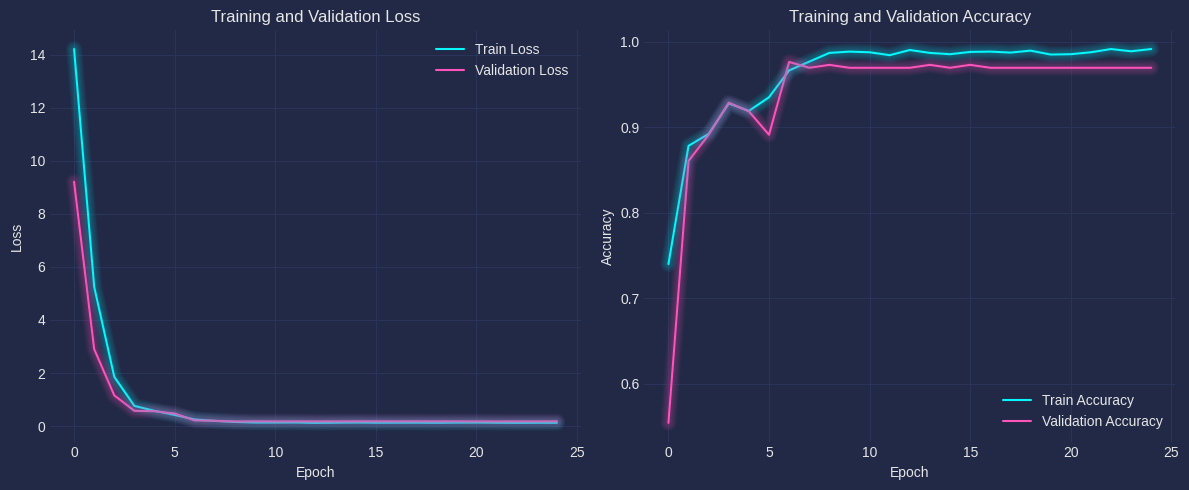

In [61]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 692ms/step


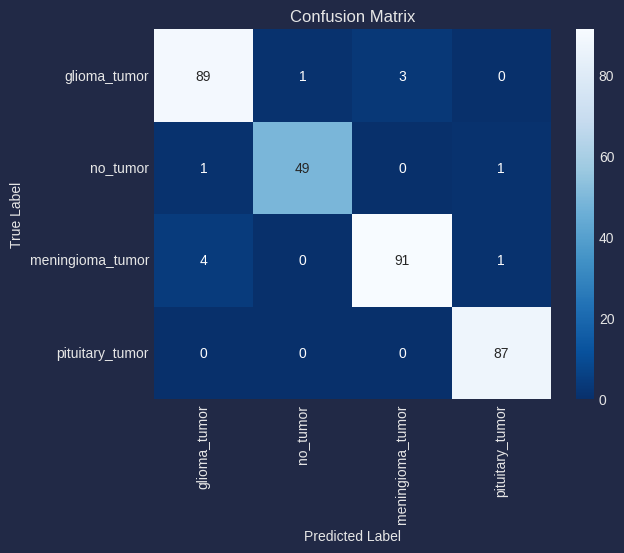

In [62]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [63]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        93
           1       0.98      0.96      0.97        51
           2       0.97      0.95      0.96        96
           3       0.98      1.00      0.99        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 99.94%



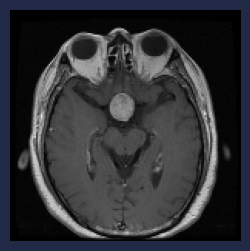

In [75]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()
model.save('testv2.keras')

In [51]:
import numpy as np

# Benzersiz sınıfları ve sayımlarını elde etme
train_classes, train_counts = np.unique(y_train, return_counts=True)
print("Eğitim verileri sınıf dağılımı:")
for cls, count in zip(train_classes, train_counts):
    print(f"Sınıf {cls}: {count}")

test_classes, test_counts = np.unique(y_test, return_counts=True)
print("Test verileri sınıf dağılımı:")
for cls, count in zip(test_classes, test_counts):
    print(f"Sınıf {cls}: {count}")

Eğitim verileri sınıf dağılımı:
Sınıf 0.0: 7833
Sınıf 1.0: 2611
Test verileri sınıf dağılımı:
Sınıf 0.0: 1959
Sınıf 1.0: 653
